In [1]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# info tables
sim_info = f'/data01/homes/dipiano/E4/irf_random/crab/map_100s_200x200/merged_simulator_data.dat'
map_info = f'/data01/homes/dipiano/E4/irf_random/crab/map_100s_200x200/merged_mapper_data.dat'

# dataset 
filename = '/data01/homes/dipiano/E4/irf_random/crab/cleaner_100s_5sgm_5000sz_200x200_YESnorm_NOstretch.npy'
ds = np.load(filename, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
print(f"Classes: {ds.keys()}\n")
print(f"NOISY dataset size: {len(ds['DS1'])}")
print(f"CLEAN dataset size: {len(ds['DS2'])}")

print(ds['DS1'][0].shape)

Classes: dict_keys(['DS1', 'DS2'])

NOISY dataset size: 5000
CLEAN dataset size: 5000
(200, 200)


In [2]:
from astroai.tools.utils import split_noisy_dataset

train_noisy, train_clean, test_noisy, test_clean = split_noisy_dataset(ds, split=80, reshape=True, binning=200)

print(f"Train clean: {train_clean.shape}")
print(f"Train noisy: {train_noisy.shape}")
print(f"\nTest clean: {test_clean.shape}")
print(f"Test labenoicyls: {test_noisy.shape}")

Train clean: (4000, 200, 200, 1)
Train noisy: (4000, 200, 200, 1)

Test clean: (1000, 200, 200, 1)
Test labenoicyls: (1000, 200, 200, 1)


In [3]:
sim_data = pd.read_csv(sim_info, sep=' ', header=0).sort_values(by=['seed'])
sim_data.head()

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
15000,crab_00001,1,0,100,100,57.265654,30.447065,57.253328,30.454269,0.012838,North_z40_S_0.5h_LST,2.5,7.322825
15001,crab_00002,2,0,100,100,98.177801,40.950640,98.016897,41.081760,0.178695,North_z60_N_50h_LST,2.5,6.762409
15002,crab_00003,3,0,100,100,76.984211,-66.348920,78.358890,-67.138246,0.957894,North_z40_N_5h_LST,2.5,7.029939
15003,crab_00004,4,0,100,100,125.495725,-44.424075,126.479118,-43.608941,1.079135,North_z40_5h_LST,2.5,7.074566
15004,crab_00005,5,0,100,100,214.162576,42.736282,215.790559,43.357500,1.342109,North_z20_5h_LST,2.5,7.087336


In [4]:
map_data = pd.read_csv(map_info, sep=' ', header=0).sort_values(by=['seed'])
map_data.head()

,name,seed,exposure,center_on,pixelsize,smooth,map_time
20000,crab_00001,1,100,pointing,0.025,5,0.784925
20001,crab_00002,2,100,pointing,0.025,5,0.671861
20002,crab_00003,3,100,pointing,0.025,5,0.751750
20003,crab_00004,4,100,pointing,0.025,5,0.767258
20004,crab_00005,5,100,pointing,0.025,5,0.695176


4127


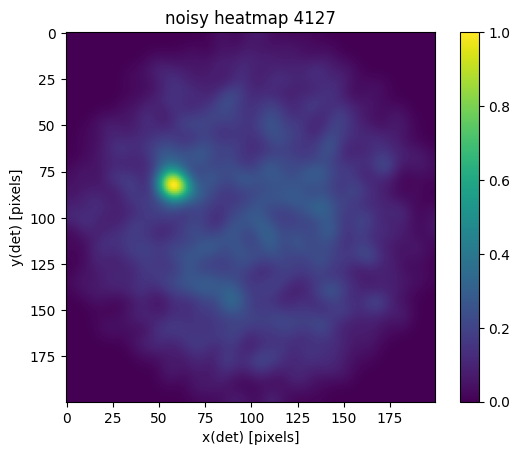

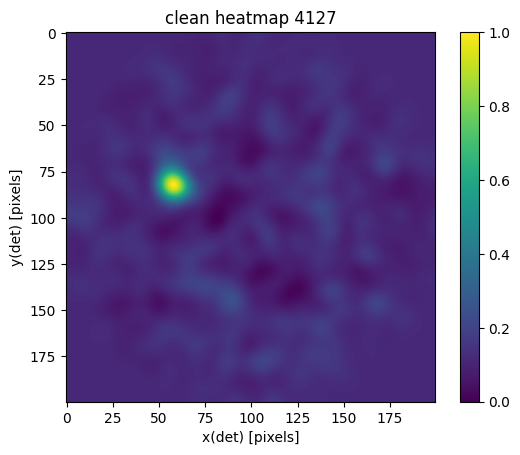

In [5]:
from astroai.tools.utils import plot_heatmap

idx = np.random.choice(range(len(test_noisy)))
# find seed to get the original heatmap
seed = len(train_noisy) + idx + 1
print(seed)

plot_heatmap(test_noisy[idx], title=f'noisy heatmap {seed}', show=True, save=False, save_name=None)
plot_heatmap(test_clean[idx], title=f'clean heatmap {seed}', show=True, save=False, save_name=None)

## Load model and weights

In [6]:
import tensorflow as tf

savename = 'cleaner_200x200_filter6_500p' 
model = tf.keras.models.load_model(f'../models/{savename}.keras')
model.summary()

2024-02-09 16:13:28.035121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-09 16:13:28.167093: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-09 16:13:28.167120: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-02-09 16:13:29.171724: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 6)       30        
                                                                 
 average_pooling2d (AverageP  (None, 100, 100, 6)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 6)       150       
                                                                 
 average_pooling2d_1 (Averag  (None, 50, 50, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 6)         150   

2024-02-09 16:13:30.134928: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-02-09 16:13:30.135056: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (morgana): /proc/driver/nvidia/version does not exist
2024-02-09 16:13:30.136436: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# load from checkpoints (if need to)
#model.load_weights('../models/checkpoints/cnn_clean_20231221T124633')

32/32 [==============================] - 1s 39ms/step


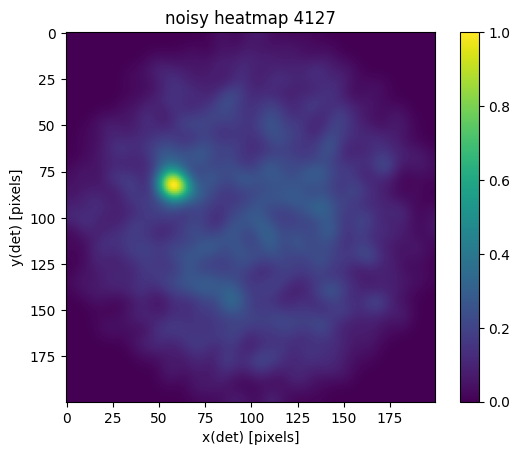

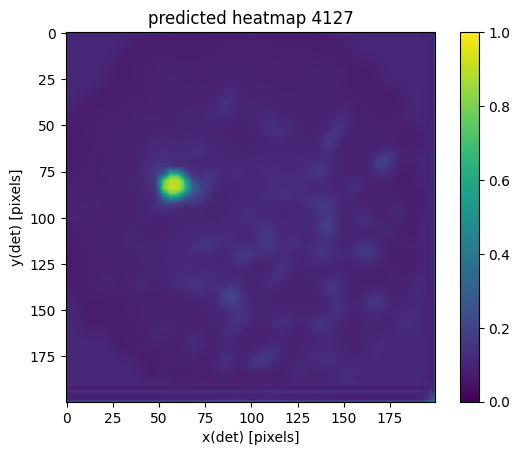

In [8]:
predictions = model.predict(test_noisy)

# plot noisy and prediction
plot_heatmap(test_noisy[idx], title=f'noisy heatmap {seed}', show=True, save=False, save_name=None)
plot_heatmap(predictions[idx], title=f'predicted heatmap {seed}', show=True, save=False, save_name=None)

# Revert normalisation

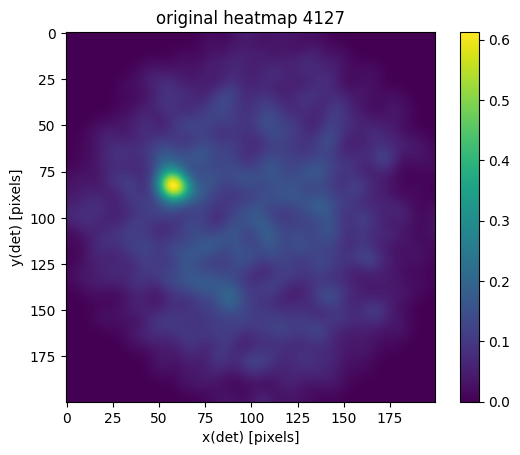

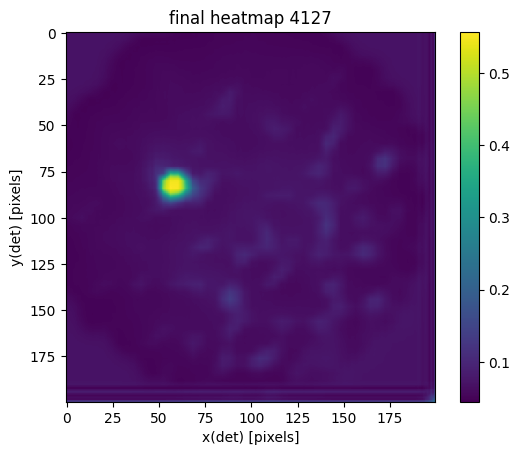

In [9]:
import numpy as np
from astropy.table import Table
from astroai.tools.utils import revert_normalise_heatmap
from astroai.tools.utils import extract_heatmap_from_table, normalise_heatmap

original = f'/data01/homes/dipiano/E4/irf_random/crab/sim/crab_{seed:05d}.fits'
original_heatmap = Table.read(original, hdu=1).to_pandas()
original_heatmap = extract_heatmap_from_table(original_heatmap, trange=[0, 100], smoothing=5, nbins=200)
plot_heatmap(np.rot90(original_heatmap), title=f'original heatmap {seed}', show=True, save=False, save_name=None, vnorm=False)

revert_norm_heatmap = revert_normalise_heatmap(predictions[idx], original_heatmap)
plot_heatmap(revert_norm_heatmap, title=f'final heatmap {seed}', show=True, save=False, save_name=None, vnorm=False)

In [10]:
np.max(original_heatmap), np.max(revert_norm_heatmap)

(0.6125517050485356, 0.55641496)

# Plot loss

In [11]:
loss = model.evaluate(test_noisy, test_clean, verbose=2)

32/32 - 2s - loss: 0.3726 - 2s/epoch - 48ms/step


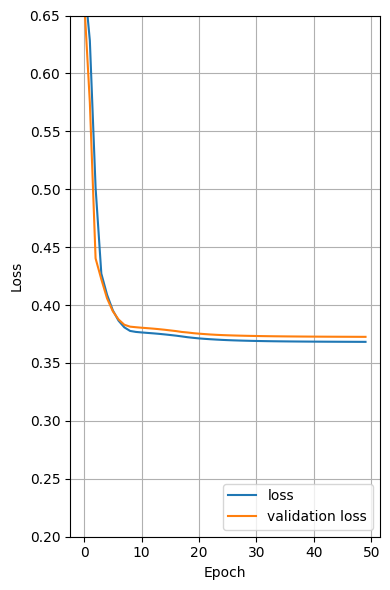

In [12]:
import matplotlib.pyplot as plt

history = np.load(f'/data01/homes/dipiano/astroAI/astroai/models/{savename}_history.npy', 
                  allow_pickle='TRUE').item()


fig, ax = plt.subplots(figsize=(4, 6))

ax.plot(history['loss'], label='loss')
ax.plot(history['val_loss'], label = 'validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_ylim([0.2,0.65])
ax.grid()
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Verify flux and excess

In [13]:
row = sim_data[sim_data['seed']==seed]
row

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
19126,crab_04127,4127,0,100,100,343.181764,71.490537,341.757259,72.539161,1.137061,North_z60_S_5h_LST,2.5,6.443971


In [14]:
from astroai.tools.utils import set_wcs
from astropy.coordinates import SkyCoord

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)
point_ref, pixelsize

(100.0125, 0.025)

In [15]:
source_x, source_y = w.world_to_pixel(SkyCoord(row['source_ra'].values[0], row['source_dec'].values[0], 
                                                  unit='deg', frame='icrs'))
point_x, point_y = w.world_to_pixel(SkyCoord(row['point_ra'].values[0], row['point_dec'].values[0], 
                                                  unit='deg', frame='icrs'))

source_x, source_y, point_x, point_y

(array(80.93468127), array(57.29457386), array(99.025), array(99.025))

In [16]:
source_pix = {'ra': source_x, 'dec': source_y}
point_pix = {'ra': point_x, 'dec': point_y}
source_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
point_deg = {'ra': row['point_ra'].values[0], 'dec': row['point_dec'].values[0]}

source_pix, point_pix, source_deg, point_deg

({'ra': array(80.93468127), 'dec': array(57.29457386)},
 {'ra': array(99.025), 'dec': array(99.025)},
 {'ra': 343.1817635746844, 'dec': 71.49053671275735},
 {'ra': 341.75725949844866, 'dec': 72.53916062212622})

In [17]:
from rtasci.aph.utils import heatmap_photometrics_counts, photometrics_counts

# photometry on DL3
dl3_ph = photometrics_counts(events_list=original, events_type='events_filename',
                             pointing=point_deg, true_coords=source_deg, region_rad=0.2, 
                             skip_adjacent=False, min_regions_number=2)
# 
original_ph = heatmap_photometrics_counts(events_list=original_heatmap, events_type='events_list', 
                                          pointing=point_deg, true_coords=source_deg, region_rad=0.2, 
                                          skip_adjacent=False, min_regions_number=2, binning=200)
predicted_ph = heatmap_photometrics_counts(events_list=revert_norm_heatmap, events_type='events_list', 
                                           pointing=point_deg, true_coords=source_deg, region_rad=0.2, 
                                           skip_adjacent=False, min_regions_number=2, binning=200)


original_ph, predicted_ph, dl3_ph

ValueError: Latitude angle(s) must be within -90 deg <= angle <= 90 deg, got [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 197. 198. 199. 200.] deg

In [ ]:
np.arange(200+1)